In [1]:
import pandas as pd
import sqlite3
import os
from pathlib import Path
home_dir=Path(os.getcwd()).parent

db_path=os.path.join(home_dir, 'mushrooms_database.db')
print (db_path)
if os.path.exists(db_path):
    con=sqlite3.connect(db_path)
else:
    print ("mushrooms_database.db does not exist please check the db_path")


/home/ibadski/Desktop/sensyne_health_ml_engineer/mushrooms_database.db


### Different Species identified by attributes 1-20

In [2]:
Q1='''
select cap_shape_id  from mushrooms union 
select cap_color_id from mushrooms UNION 
select odor_id from mushrooms UNION
select gill_size_id from mushrooms UNION
select stalk_color_above_ring_id FROM mushrooms UNION
select veil_color_id from mushrooms UNION
select ring_type_id from mushrooms UNION
select spore_print_color_id from mushrooms
'''
df=pd.read_sql_query(Q1,con)

print (sorted(df['cap_shape_id'].values))

['almond', 'anise', 'bell', 'black', 'broad', 'brown', 'buff', 'chocolate', 'cinnamon', 'conical', 'convex', 'creosote', 'evanescent', 'fishy', 'flaring', 'flat', 'foul', 'gray', 'green', 'knobbed', 'large', 'musty', 'narrow', 'none', 'orange', 'pendant', 'pink', 'pungent', 'purple', 'red', 'spicy', 'sunken', 'white', 'yellow']


### Correlation between habitat and cap-color
#### Because both of them are categorical values hence we first get the data grouped by each of it then with that create the contingency table
#### Then we perform Chi-Square  

In [3]:
Q2='''select habitat_id, cap_color_id,
count(*) as count 
from mushrooms
group by habitat_id, cap_color_id
'''

df=pd.read_sql_query(Q2,con)

In [4]:
habitat_values=sorted(list(set(list(df['habitat_id'].values))))
cap_color_values=sorted(list(set(list(df['cap_color_id'].values))))

cont_data={}
for val in habitat_values:
    cont_data[val]=[0 for i in range(len(cap_color_values))]
    

contingency_df=pd.DataFrame(cont_data,index=cap_color_values)

for i,x in df.iterrows():
    hab=x['habitat_id']
    cap=x['cap_color_id']
    count=x['count']
    contingency_df.loc[cap][hab]=count
print (contingency_df)

          grasses  leaves  meadows  paths  urban  waste  woods
brown         368     504        0    352    112     48    900
buff           60       0       12      0     48     48      0
cinnamon        0      24        0      8      0      0     12
gray          664       0        0    224     96      0    856
green           0       0        0      0      0      0     16
pink           12       0       12      8      0     48     64
purple          0       0        0      0      0      0     16
red             0     288        0    288      0     48    876
white         652       8      140      0    112      0    128
yellow        392       8      128    264      0      0    280


### We now perform the Chi Square Test on the categorical values to find the p value. 

In [5]:
from scipy.stats import chi2_contingency
import numpy as np
c, p, dof, expected = chi2_contingency(contingency_df.values, correction=False)
print ("P Value is ", p)
print ("Degree of Freedom is : ", dof)
#Since there are total 7 columns and 10 rows hence dof is (r-1)(c-1)

P Value is  0.0
Degree of Freedom is :  54


## Since P value is 0 hence it means that means we can reject the null hypothesis and that habitat and cap-color are dependant

### We perform another test which is Crammer V to further strenghten our argument

In [6]:
n = np.sum(contingency_df.values)
minDim = min(contingency_df.values.shape)-1
V = np.sqrt((c/n) / minDim)
print (V)

0.3267789015188318


### The above value clear that there is a weak positive correlation between Habitat and cap-color

### q3 Considering a specific geographical point, what colours should we be able to see in the 10 km around it?
#### This seems a little confusing as there isnt any specific geographical point specified and there is no distance metric in the table
#### for this question i will assume that by geographical point it means habitat that either its grasses, meadows etc.
#### for the colours i will assume it is the cap-color.
#### for this question i will try to find that which colours are more prominent for each geographical region
### for this the same query as Q2 will do the job since we have already executed it hence we will go directly towards visualisations

In [7]:
habitats_unique=list(set(df['habitat_id'].values))
count_dict={}
for x in habitats_unique:
    newdf=df[df['habitat_id']==x]
    newdf=newdf[['cap_color_id','count']].sort_values('count', ascending=False)
    count_dict[x]={item['cap_color_id']:item['count'] for i, item in newdf.iterrows()}
    

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_graph(habitat_val):
    keys=count_dict[habitat_val].keys()
    values=count_dict[habitat_val].values()
    plt.clf()
    plt.bar(keys,values)
    plt.xticks(rotation=80)
    plt.title("Bar Chart for "+habitat_val+" with count of each color")
    plt.show()

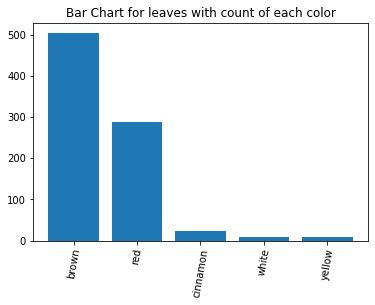

In [9]:
plot_graph('leaves')

#### it can be seen ABOVE that brown is the color we are more likely to see in the leaves habitat

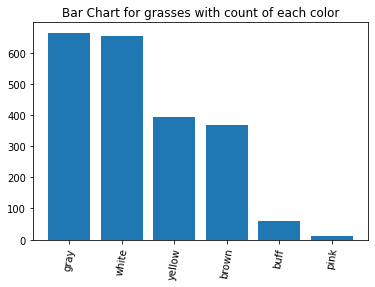

In [10]:
plot_graph('grasses')

#### it can be seen ABOVE that gray is the color we are more likely to see in the grasses habitat

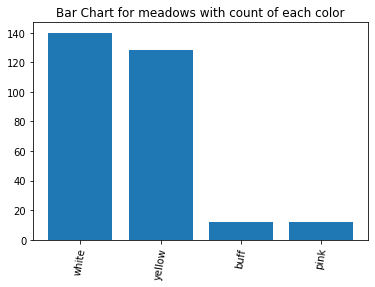

In [11]:
plot_graph('meadows')

#### it can be seen ABOVE that white is the color we are more likely to see in the meadows habitat

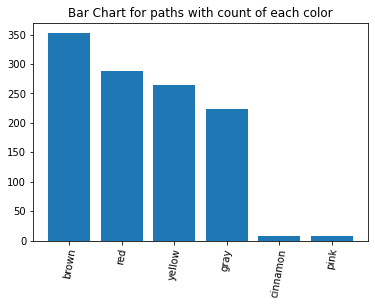

In [12]:
plot_graph('paths')

#### it can be seen ABOVE that brown is the color we are more likely to see in the paths habitat

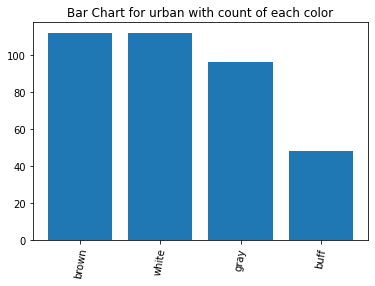

In [13]:
plot_graph('urban')

#### it can be seen ABOVE that brown is the color we are more likely to see in the urban habitat

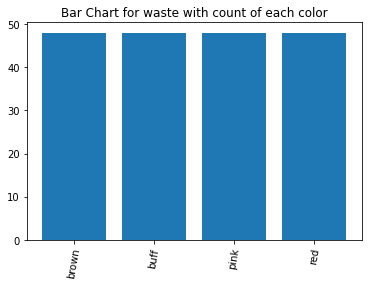

In [14]:
plot_graph('waste')

#### it can be seen ABOVE that all colours are equally likely in waste habitat

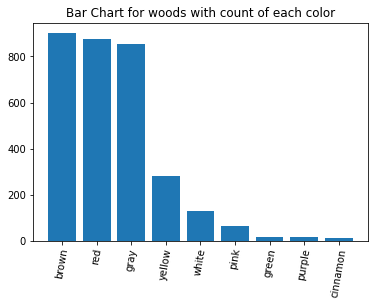

In [15]:
plot_graph('woods')

#### it can be seen ABOVE that brown, red and gray is the color we are more likely to see in the woods habitat